In [1]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import ktrain
from ktrain import tabular
import os
import glob
import optuna
import pickle
import json

def read_and_combine(mode="training"):
    if mode=="training":
        all_files = glob.glob(os.path.join("./training_data", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
        return df.loc[:,cols]
    elif mode=="testing":
        all_files = glob.glob(os.path.join("./testing_data", "*.csv"))
        df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
        return df.loc[:,cols]
    
def read_hardware():
    all_files = glob.glob(os.path.join("./real_circuits_hardware/", "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    cols = [x for x in df.columns if x not in ["Avg_inverted_error","observed_prob_25","observed_prob_75"]]
    return df.loc[:,cols]

# LGBM MODEL

In [26]:
def objective_lgb(trial):
    data = read_and_combine()
    #class_label = (data["target"]!=0).values
    target = data.pop("target")
    
    kf = KFold(n_splits=5)
    mae = []
    param = {
            "objective": "regression",
            "metric": "l2",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 20),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train_x = data.loc[train_index]
        valid_x = data.loc[test_index]
        train_y = target.loc[train_index]
        valid_y = target.loc[test_index]
    
        dtrain = lgb.Dataset(train_x, label=train_y)
        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(valid_x)
        mae.append(mean_squared_error(valid_y,preds))
    return np.mean(mae)

study = optuna.create_study(direction="minimize")
study.optimize(objective_lgb, n_trials=100)
trial = study.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 15:15:45,980] A new study created in memory with name: no-name-1c255426-dafe-40c6-8b0d-ea9e0d8f73d5
[I 2023-07-25 15:15:46,569] Trial 0 finished with value: 41.70259448584833 and parameters: {'lambda_l1': 0.2567500393716737, 'lambda_l2': 6.230766304713824e-05, 'num_leaves': 171, 'feature_fraction': 0.8793645298066182, 'bagging_fraction': 0.6877997212534146, 'bagging_freq': 8, 'min_child_samples': 80}. Best is trial 0 with value: 41.70259448584833.
[I 2023-07-25 15:15:47,306] Trial 1 finished with value: 38.77448458337659 and parameters: {'lambda_l1': 8.45086904462748, 'lambda_l2': 8.417255105566764e-07, 'num_leaves': 79, 'feature_fraction': 0.9230294911704036, 'bagging_fraction': 0.48460068624047736, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 1 with value: 38.77448458337659.
[I 2023-07-25 15:15:48,954] Trial 2 finished with value: 36.23747016361692 and parameters: {'lambda_l1': 4.983546699102459e-07, 'lambda_l2': 0.07285134740985402, 'num_leaves': 182, 'fe

[I 2023-07-25 15:16:09,624] Trial 23 finished with value: 34.069872060733 and parameters: {'lambda_l1': 0.06337664799811828, 'lambda_l2': 1.3642328149206652e-07, 'num_leaves': 12, 'feature_fraction': 0.6684265306915269, 'bagging_fraction': 0.9388215393007479, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:09,831] Trial 24 finished with value: 44.23002370808222 and parameters: {'lambda_l1': 0.00035346152916436257, 'lambda_l2': 1.0040276063865392e-08, 'num_leaves': 2, 'feature_fraction': 0.6044625188265554, 'bagging_fraction': 0.8795792884882326, 'bagging_freq': 11, 'min_child_samples': 24}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:10,994] Trial 25 finished with value: 35.23092094989838 and parameters: {'lambda_l1': 0.004356127784175678, 'lambda_l2': 7.518308070429046e-08, 'num_leaves': 91, 'feature_fraction': 0.7625126949913114, 'bagging_fraction': 0.9449385799804678, 'bagging_freq': 3, 'min_c

[I 2023-07-25 15:16:32,328] Trial 47 finished with value: 32.97893619174317 and parameters: {'lambda_l1': 0.32754309332625686, 'lambda_l2': 2.450054936645387e-06, 'num_leaves': 78, 'feature_fraction': 0.628719565072475, 'bagging_fraction': 0.9663419682550947, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:34,135] Trial 48 finished with value: 34.284265244889056 and parameters: {'lambda_l1': 0.36620768797710795, 'lambda_l2': 3.866383970758424e-06, 'num_leaves': 85, 'feature_fraction': 0.6235544088276257, 'bagging_fraction': 0.9120990920081513, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:35,315] Trial 49 finished with value: 32.245229431509415 and parameters: {'lambda_l1': 0.1394921115528681, 'lambda_l2': 3.9927211378372816e-08, 'num_leaves': 70, 'feature_fraction': 0.6413578414332005, 'bagging_fraction': 0.9815307064515513, 'bagging_freq': 4, 'min_child

[I 2023-07-25 15:16:56,100] Trial 71 finished with value: 33.6128065015752 and parameters: {'lambda_l1': 0.01905134081225683, 'lambda_l2': 1.8403169463737986e-06, 'num_leaves': 69, 'feature_fraction': 0.6580062361355117, 'bagging_fraction': 0.8939492553461381, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:56,790] Trial 72 finished with value: 33.60119054729403 and parameters: {'lambda_l1': 0.5969438229403475, 'lambda_l2': 6.637784856041015e-07, 'num_leaves': 37, 'feature_fraction': 0.5837086870462618, 'bagging_fraction': 0.982757674605857, 'bagging_freq': 8, 'min_child_samples': 5}. Best is trial 14 with value: 31.776806663197316.
[I 2023-07-25 15:16:57,715] Trial 73 finished with value: 36.09467022896412 and parameters: {'lambda_l1': 0.06736498548207467, 'lambda_l2': 2.3663911410518693e-07, 'num_leaves': 57, 'feature_fraction': 0.7156688765292438, 'bagging_fraction': 0.9347247362531841, 'bagging_freq': 11, 'min_child_s

[I 2023-07-25 15:17:12,064] Trial 94 finished with value: 33.298295392546535 and parameters: {'lambda_l1': 0.00016145206189364375, 'lambda_l2': 2.48358209812963e-07, 'num_leaves': 23, 'feature_fraction': 0.7048334352745212, 'bagging_fraction': 0.9612462313332442, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 81 with value: 31.649144847967005.
[I 2023-07-25 15:17:14,627] Trial 95 finished with value: 34.56379360375372 and parameters: {'lambda_l1': 0.00809190439457174, 'lambda_l2': 3.382848889452372e-08, 'num_leaves': 185, 'feature_fraction': 0.6347823382441797, 'bagging_fraction': 0.9330004064373, 'bagging_freq': 9, 'min_child_samples': 9}. Best is trial 81 with value: 31.649144847967005.
[I 2023-07-25 15:17:15,276] Trial 96 finished with value: 33.659283497701516 and parameters: {'lambda_l1': 0.0036520236147393457, 'lambda_l2': 5.695138186434038e-08, 'num_leaves': 34, 'feature_fraction': 0.7229124063627644, 'bagging_fraction': 0.9475732330065924, 'bagging_freq': 5, 'min_chi

  Params: 
    lambda_l1: 0.0029496100993287797
    lambda_l2: 1.2591090017658295e-07
    num_leaves: 29
    feature_fraction: 0.7423858861358075
    bagging_fraction: 0.980041118597475
    bagging_freq: 8
    min_child_samples: 5


In [27]:
Best_lgbm_params = {}
for key, value in trial.params.items():
    Best_lgbm_params[key] = value

data = read_and_combine()
target = data.pop("target")
test_data = read_and_combine("testing")
test_target = test_data.pop("target")
dtrain = lgb.Dataset(data, label=target)
lgbm = lgb.train(Best_lgbm_params, dtrain)
preds = lgbm.predict(test_data)
print(mean_squared_error(test_target.values/100,preds/100))
lgbm.save_model('lgbm.txt', num_iteration=lgbm.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1511
[LightGBM] [Info] Number of data points in the train set: 9486, number of used features: 10
[LightGBM] [Info] Start training from score 4.722846
0.004187115614246169


# XGBOOST

In [28]:
def objective_xgb(trial):
    data = read_and_combine()
    #class_label = (data["target"]!=0).values
    target = data.pop("target")    
    kf = KFold(n_splits=5)
    mae = []
    param = {
                "verbosity": 0,
                "objective": "reg:squarederror",
                # use exact for small dataset.
                "tree_method": "exact",
                # defines booster, gblinear for linear functions.
                "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
                # L2 regularization weight.
                "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
                # L1 regularization weight.
                "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
                # sampling ratio for training data.
                "subsample": trial.suggest_float("subsample", 0.2, 1.0),
                # sampling according to each tree.
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train_x = data.loc[train_index]
        valid_x = data.loc[test_index]
        train_y = target.loc[train_index]
        valid_y = target.loc[test_index]
    
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dvalid = xgb.DMatrix(valid_x, label=valid_y)

        xgbm = xgb.train(param, dtrain)
        preds = xgbm.predict(dvalid)
        mae.append(mean_squared_error(valid_y,preds))
    return np.mean(mae)

study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb, n_trials=100)
trial = study.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 15:17:44,138] A new study created in memory with name: no-name-c73695a8-21fc-4478-9717-ebc19247fe88
[I 2023-07-25 15:17:44,302] Trial 0 finished with value: 165.56420237479594 and parameters: {'booster': 'gbtree', 'lambda': 0.0002849989654579484, 'alpha': 2.908822819558731e-08, 'subsample': 0.2072097421445517, 'colsample_bytree': 0.4277121752437659, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.012691416051071065, 'gamma': 0.024634903450578935, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 165.56420237479594.
[I 2023-07-25 15:17:44,399] Trial 1 finished with value: 84286.20189474193 and parameters: {'booster': 'gblinear', 'lambda': 0.0010467600615590546, 'alpha': 0.009301339951877576, 'subsample': 0.8077790914655161, 'colsample_bytree': 0.434071043131128}. Best is trial 0 with value: 165.56420237479594.
[I 2023-07-25 15:17:44,487] Trial 2 finished with value: 73631.99641433114 and parameters: {'booster': 'gblinear', 'lambda': 0.008420526824054433, 'alpha': 0.

[I 2023-07-25 15:17:47,475] Trial 18 finished with value: 142.67613571140063 and parameters: {'booster': 'gbtree', 'lambda': 0.15652953465854616, 'alpha': 2.6805951988699634e-06, 'subsample': 0.9005466894785719, 'colsample_bytree': 0.39544101364754936, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.03554307693138106, 'gamma': 0.005429262282512129, 'grow_policy': 'depthwise'}. Best is trial 15 with value: 39.49944439482881.
[I 2023-07-25 15:17:47,722] Trial 19 finished with value: 45.88299763909449 and parameters: {'booster': 'dart', 'lambda': 0.7916724633365978, 'alpha': 1.1295841004158011e-06, 'subsample': 0.981855864152001, 'colsample_bytree': 0.4976081867114173, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.794019059811298, 'gamma': 9.748688713129118e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.830118623421938e-06, 'skip_drop': 0.0017399529395164422}. Best is trial 15 with value: 39.49944439482881.
[I 2023-07-25 15:17:47,97

[I 2023-07-25 15:17:51,481] Trial 34 finished with value: 143.66865778329728 and parameters: {'booster': 'dart', 'lambda': 0.18027415307644806, 'alpha': 1.1523891324989407e-06, 'subsample': 0.8099567533027476, 'colsample_bytree': 0.35726694382980595, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.03166909677624742, 'gamma': 0.00016425939873124487, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.10670337335121e-05, 'skip_drop': 0.002063183136595553}. Best is trial 15 with value: 39.49944439482881.
[I 2023-07-25 15:17:51,717] Trial 35 finished with value: 54.12862268847476 and parameters: {'booster': 'dart', 'lambda': 0.0411763649909964, 'alpha': 4.749038925109635e-08, 'subsample': 0.8680262681944356, 'colsample_bytree': 0.3708811524147615, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.21736549789175655, 'gamma': 0.005883331008284408, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.04822

[I 2023-07-25 15:17:55,547] Trial 52 finished with value: 43.07764942281998 and parameters: {'booster': 'dart', 'lambda': 0.009750386451216652, 'alpha': 5.802057490133517e-07, 'subsample': 0.7848749097154055, 'colsample_bytree': 0.3367660620931079, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.39730590474813543, 'gamma': 0.11347815992409409, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.7333633252749853e-05, 'skip_drop': 3.4773643141630783e-06}. Best is trial 15 with value: 39.49944439482881.
[I 2023-07-25 15:17:55,784] Trial 53 finished with value: 44.10988747169265 and parameters: {'booster': 'dart', 'lambda': 0.0019100357862644561, 'alpha': 6.559510577892744e-07, 'subsample': 0.7676408924714314, 'colsample_bytree': 0.3017009384329425, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.36072127306001567, 'gamma': 0.2038027763677979, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.3012282

[I 2023-07-25 15:17:59,288] Trial 68 finished with value: 91.72809283640933 and parameters: {'booster': 'dart', 'lambda': 2.4261578317266387e-05, 'alpha': 1.3214327664012064e-08, 'subsample': 0.7215292157125043, 'colsample_bytree': 0.42207562899901296, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.10185035920139586, 'gamma': 0.44260755988707823, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00013746349110939625, 'skip_drop': 1.1358141645574788e-05}. Best is trial 15 with value: 39.49944439482881.
[I 2023-07-25 15:17:59,541] Trial 69 finished with value: 49.654383251878194 and parameters: {'booster': 'dart', 'lambda': 7.101342420891841e-06, 'alpha': 2.0900551687239075e-08, 'subsample': 0.6779100235653447, 'colsample_bytree': 0.24950673913977184, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.4335787048968585, 'gamma': 0.11786144208005075, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.5

[I 2023-07-25 15:18:03,080] Trial 84 finished with value: 41.858946888243175 and parameters: {'booster': 'dart', 'lambda': 0.00018430356308799382, 'alpha': 1.6319291982537485e-08, 'subsample': 0.690777037047297, 'colsample_bytree': 0.3779036845848902, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.6010556141470988, 'gamma': 0.7625437034643215, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.7148728487207427e-06, 'skip_drop': 3.968169944086585e-05}. Best is trial 71 with value: 38.71331907400167.
[I 2023-07-25 15:18:03,331] Trial 85 finished with value: 57.97229011769417 and parameters: {'booster': 'dart', 'lambda': 0.0002827864991584286, 'alpha': 6.042404413224809e-08, 'subsample': 0.750377254840915, 'colsample_bytree': 0.3548603359285881, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.22169790920716698, 'gamma': 0.22177062000926878, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.07669998

  Params: 
    booster: dart
    lambda: 0.00018118058363885545
    alpha: 2.9479046022605927e-08
    subsample: 0.694953130236263
    colsample_bytree: 0.36352088822220663
    max_depth: 3
    min_child_weight: 5
    eta: 0.6688340656910564
    gamma: 0.9978262735952943
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: tree
    rate_drop: 4.088760178332561e-06
    skip_drop: 0.00013520622401441132


In [29]:
Best_xgbm_params = {}
for key, value in trial.params.items():
    Best_xgbm_params[key] = value


data = read_and_combine()
target = data.pop("target")
test_data = read_and_combine("testing")
test_target = test_data.pop("target")

dtrain = xgb.DMatrix(data,target)
dtest  = xgb.DMatrix(test_data,test_target)
xgbm = xgb.train(Best_xgbm_params, dtrain)
preds = xgbm.predict(dtest)
print(mean_squared_error(test_target.values/100,preds/100))
with open("xgbparam","w") as file:
    json.dump(Best_xgbm_params,file)
xgbm.save_model("xgbm.json")

0.004229226531825859


# Ensamble of Decision Tree

In [30]:
def objective_edt(trial):
    data = read_and_combine()
    #class_label = (data["target"]!=0).values
    target = data.pop("target")
    
    kf = KFold(n_splits=5)
    mae = []
    n_estimators = trial.suggest_int("n_estimators", 10, 256)
    max_samples = trial.suggest_int("max_samples", 1, 256)
    max_features = trial.suggest_int("max_features", 1, len(data.columns))
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train_x = data.loc[train_index]
        valid_x = data.loc[test_index]
        train_y = target.loc[train_index]
        valid_y = target.loc[test_index]
        edt = BaggingRegressor(n_estimators=n_estimators,max_samples=max_samples,max_features=max_features)
        edt.fit(train_x,train_y)
        preds = edt.predict(valid_x)
        mae.append(mean_squared_error(valid_y,preds))
        
    return np.mean(mae)

study = optuna.create_study(direction="minimize")
study.optimize(objective_edt, n_trials=100)
trial = study.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 15:18:43,247] A new study created in memory with name: no-name-da373879-99e7-4739-a278-518f484fb9b1
[I 2023-07-25 15:18:44,378] Trial 0 finished with value: 123.05571232560916 and parameters: {'n_estimators': 228, 'max_samples': 21, 'max_features': 4}. Best is trial 0 with value: 123.05571232560916.
[I 2023-07-25 15:18:45,962] Trial 1 finished with value: 55.544880567753864 and parameters: {'n_estimators': 147, 'max_samples': 208, 'max_features': 8}. Best is trial 1 with value: 55.544880567753864.
[I 2023-07-25 15:18:47,597] Trial 2 finished with value: 54.969698880045755 and parameters: {'n_estimators': 221, 'max_samples': 80, 'max_features': 10}. Best is trial 2 with value: 54.969698880045755.
[I 2023-07-25 15:18:49,179] Trial 3 finished with value: 61.76023787451824 and parameters: {'n_estimators': 177, 'max_samples': 166, 'max_features': 7}. Best is trial 2 with value: 54.969698880045755.
[I 2023-07-25 15:18:49,609] Trial 4 finished with value: 50.4338779452447 and pa

[I 2023-07-25 15:19:17,542] Trial 41 finished with value: 43.574114219108296 and parameters: {'n_estimators': 178, 'max_samples': 243, 'max_features': 10}. Best is trial 41 with value: 43.574114219108296.
[I 2023-07-25 15:19:19,971] Trial 42 finished with value: 43.57880904227609 and parameters: {'n_estimators': 192, 'max_samples': 244, 'max_features': 10}. Best is trial 41 with value: 43.574114219108296.
[I 2023-07-25 15:19:22,297] Trial 43 finished with value: 45.93988696570089 and parameters: {'n_estimators': 191, 'max_samples': 242, 'max_features': 9}. Best is trial 41 with value: 43.574114219108296.
[I 2023-07-25 15:19:24,900] Trial 44 finished with value: 43.21891373103095 and parameters: {'n_estimators': 194, 'max_samples': 242, 'max_features': 10}. Best is trial 44 with value: 43.21891373103095.
[I 2023-07-25 15:19:27,575] Trial 45 finished with value: 43.6378354038216 and parameters: {'n_estimators': 188, 'max_samples': 242, 'max_features': 10}. Best is trial 44 with value: 43

[I 2023-07-25 15:20:44,987] Trial 82 finished with value: 44.14842351426694 and parameters: {'n_estimators': 161, 'max_samples': 233, 'max_features': 10}. Best is trial 78 with value: 42.49208084534702.
[I 2023-07-25 15:20:46,843] Trial 83 finished with value: 43.41255249709219 and parameters: {'n_estimators': 151, 'max_samples': 224, 'max_features': 10}. Best is trial 78 with value: 42.49208084534702.
[I 2023-07-25 15:20:48,521] Trial 84 finished with value: 47.66541068027287 and parameters: {'n_estimators': 140, 'max_samples': 224, 'max_features': 9}. Best is trial 78 with value: 42.49208084534702.
[I 2023-07-25 15:20:50,155] Trial 85 finished with value: 44.33861874924827 and parameters: {'n_estimators': 127, 'max_samples': 237, 'max_features': 10}. Best is trial 78 with value: 42.49208084534702.
[I 2023-07-25 15:20:51,549] Trial 86 finished with value: 48.2752407274541 and parameters: {'n_estimators': 113, 'max_samples': 229, 'max_features': 9}. Best is trial 78 with value: 42.4920

  Params: 
    n_estimators: 128
    max_samples: 250
    max_features: 10


In [31]:
data = read_and_combine()
target = data.pop("target")
test_data = read_and_combine("testing")
test_target = test_data.pop("target")
edt = BaggingRegressor(n_estimators=trial.params['n_estimators'],
                       max_samples=trial.params['max_samples'],
                       max_features=trial.params['max_features'])
edt.fit(data,target)
preds = edt.predict(test_data)
print(mean_squared_error(test_target.values/100,preds/100))
with open("edt.pkl","wb") as file:
    pickle.dump(edt,file)

0.003494853331621442


# MLP

processing train: 9486 rows x 11 columns
['target']
      target
0   1.070000
1  43.459999
2   0.680000
3   1.460000
4   0.680000
processing test: 1050 rows x 11 columns
['target']
      target
0   1.270000
1   0.000000
2   0.000000
3  19.820000
4  40.040001
done.
simulating training for different learning rates... this may take a few moments...
Epoch 1/16


C:\Users\asmar\anaconda3\envs\noisepytorch\lib\site-packages\ktrain\utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


74/74 [==============================] - 1s 4ms/step - loss: 190.5919 - mse: 190.5919
Epoch 2/16
74/74 [==============================] - 0s 5ms/step - loss: 189.5105 - mse: 189.5105
Epoch 3/16
74/74 [==============================] - 0s 5ms/step - loss: 190.5968 - mse: 190.5968
Epoch 4/16
74/74 [==============================] - 0s 5ms/step - loss: 187.0385 - mse: 187.0385
Epoch 5/16
74/74 [==============================] - 0s 5ms/step - loss: 178.8241 - mse: 178.8241
Epoch 6/16
74/74 [==============================] - 0s 4ms/step - loss: 133.9864 - mse: 133.9864
Epoch 7/16
74/74 [==============================] - 0s 4ms/step - loss: 51.9490 - mse: 51.9490
Epoch 8/16
74/74 [==============================] - 0s 4ms/step - loss: 47.9443 - mse: 47.9443
Epoch 9/16
74/74 [==============================] - 0s 5ms/step - loss: 49.1675 - mse: 49.1675
Epoch 10/16
74/74 [==============================] - 0s 4ms/step - loss: 52.6923 - mse: 52.6923
Epoch 11/16
74/74 [=============================

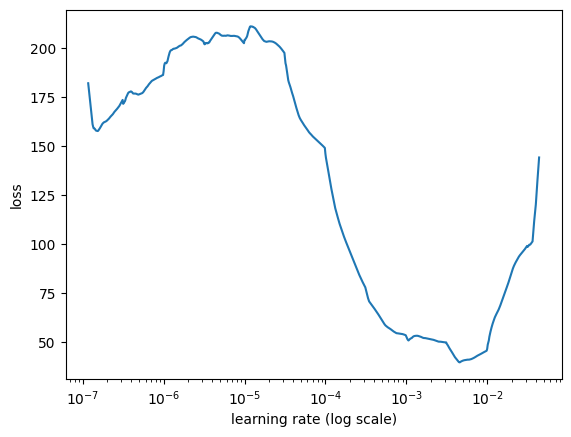

In [32]:
mlp_training_data = read_and_combine()
mlp_test_data = read_and_combine(mode="testing")
mlp_training_data = mlp_training_data.astype('float')
mlp_test_data = mlp_test_data.astype('float')

trn, val, preproc = tabular.tabular_from_df(mlp_training_data, is_regression=True, 
                                             label_columns='target', val_df=mlp_test_data)
mlp = tabular.tabular_regression_model('mlp', trn, hidden_layers=[128,1000,128],
                                       hidden_dropouts=[0,0.5,0], metrics=['mse'], bn=False)

learner = ktrain.get_learner(mlp, train_data=trn, val_data=val, batch_size=128)
learner.lr_find(show_plot=True, max_epochs=16)

In [33]:
learner.autofit(lr=1e-4,early_stopping=20,reduce_on_plateau=3)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
75/75 [==============================] - 1s 8ms/step - loss: 181.2512 - mse: 181.2512 - val_loss: 183.8155 - val_mse: 183.8155
Epoch 2/1024
75/75 [==============================] - 0s 6ms/step - loss: 156.6516 - mse: 156.6516 - val_loss: 150.9455 - val_mse: 150.9455
Epoch 3/1024
75/75 [==============================] - 1s 7ms/step - loss: 122.6874 - mse: 122.6874 - val_loss: 102.4806 - val_mse: 102.4806
Epoch 4/1024
75/75 [==============================] - 0s 6ms/step - loss: 83.3016 - mse: 83.3016 - val_loss: 62.9051 - val_mse: 62.9051
Epoch 5/1024
75/75 [==============================] - 0s 6ms/step - loss: 59.0502 - mse: 59.0502 - val_loss: 44.8111 - val_mse: 44.8111
Epoch 6/1024
75/75 [==============================] - 0s 6ms/step - loss: 50.4731 - mse: 50.4731 - val_loss: 42.1076 - val_mse: 42.1076
Epoch 7/1024
75/75 [==============================] - 0s 6ms/step - loss: 49.1024 - mse: 49.

72/75 [===========================>..] - ETA: 0s - loss: 34.9256 - mse: 34.9256
Epoch 00112: Reducing Max LR on Plateau: new max lr will be 7.8125e-07 (if not early_stopping).
75/75 [==============================] - 0s 6ms/step - loss: 33.9534 - mse: 33.9534 - val_loss: 30.4783 - val_mse: 30.4783
Epoch 113/1024
75/75 [==============================] - 0s 6ms/step - loss: 34.8835 - mse: 34.8835 - val_loss: 30.4740 - val_mse: 30.4740
Epoch 114/1024
75/75 [==============================] - 0s 6ms/step - loss: 34.3490 - mse: 34.3490 - val_loss: 30.4756 - val_mse: 30.4756
Epoch 115/1024
73/75 [============================>.] - ETA: 0s - loss: 34.3309 - mse: 34.3309
Epoch 00115: Reducing Max LR on Plateau: new max lr will be 3.90625e-07 (if not early_stopping).
75/75 [==============================] - 0s 6ms/step - loss: 34.7545 - mse: 34.7545 - val_loss: 30.4587 - val_mse: 30.4587
Epoch 116/1024
75/75 [==============================] - 0s 7ms/step - loss: 34.3894 - mse: 34.3894 - val_loss:

In [34]:
mlp_predictor = ktrain.get_predictor(learner.model, preproc)
preds = mlp_predictor.predict(mlp_test_data)
print(mean_squared_error(mlp_test_data["target"].values/100,preds/100))
mlp_predictor.save("mlp")

['target']
      target
0   1.270000
1   0.000000
2   0.000000
3  19.820000
4  40.040001
0.003042495262725605


In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
train = read_and_combine()
target = train.pop("target")
test = read_and_combine("testing")
test_target = test.pop("target")
Lreg = LinearRegression()
Lreg.fit(train.values,target.values)
preds = Lreg.predict(test.values)
with open("lreg.pkl","wb") as file:
    pickle.dump(Lreg,file)
mean_squared_error(test_target.values/100, preds/100)

0.0038864685902653246

In [37]:
Rreg = Ridge()
Rreg.fit(train.values,target.values)
preds = Rreg.predict(test.values)
with open("Rreg.pkl","wb") as file:
    pickle.dump(Rreg,file)
mean_squared_error(test_target.values/100, preds/100)

0.003886465026028816

In [38]:
Lareg = Lasso()
Lareg.fit(train.values,target.values)
preds = Lareg.predict(test.values)
with open("lareg.pkl","wb") as file:
    pickle.dump(Lareg,file)
mean_squared_error(test_target.values/100, preds/100)

0.003884895093775136

In [39]:
Ereg = ElasticNet(random_state=0)
Ereg.fit(train.values,target.values)
preds = Ereg.predict(test.values)
with open("Ereg.pkl","wb") as file:
    pickle.dump(Ereg,file)
mean_squared_error(test_target.values/100, preds/100)

0.0038766718667450537

In [40]:
from sklearn.svm import SVR
Sreg = SVR()
Sreg.fit(train.values,target.values)
preds = Sreg.predict(test.values)
with open("Sreg.pkl","wb") as file:
    pickle.dump(Sreg,file)
mean_squared_error(test_target.values/100, preds/100)

0.013248545419475807

In [41]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(train.values,target.values)
preds = Sreg.predict(test.values)
with open("Kreg.pkl","wb") as file:
    pickle.dump(neigh,file)
mean_squared_error(test_target.values/100, preds/100)

0.013248545419475807

# check on real hardware

In [2]:
# load models
lgbm = lgb.Booster(model_file='lgbm.txt')
xgbm = xgb.Booster()
xgbm.load_model("xgbm.json")
with open("edt.pkl","rb") as file:
    edt = pickle.load(file)
mlp_predictor = ktrain.load_predictor("mlp")
with open("lreg.pkl","rb") as file:
    lreg = pickle.load(file)
with open("Rreg.pkl","rb") as file:
    Rreg = pickle.load(file)
with open("lareg.pkl","rb") as file:
    Lareg = pickle.load(file)
with open("Ereg.pkl","rb") as file:
    Ereg = pickle.load(file)
with open("Sreg.pkl","rb") as file:
    Sreg = pickle.load(file)
with open("Kreg.pkl","rb") as file:
    Kreg = pickle.load(file)

In [3]:
data = read_hardware()
mlp_data = data.copy()
target = data.pop("target")

In [4]:
preds = mlp_predictor.predict(mlp_data)
print("mlp: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = lgbm.predict(data.values)
print("lgbm: ",np.round(mean_squared_error(target.values/100, preds/100),5))
dtest = xgb.DMatrix(data,target)
preds = xgbm.predict(dtest)
print("xgbm: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = edt.predict(data.values)
print("edt: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = lreg.predict(data.values)
print("LR: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = Rreg.predict(data.values)
print("Ridge: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = Lareg.predict(data.values)
print("Lasso: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = Ereg.predict(data.values)
print("Elasti: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = Sreg.predict(data.values)
print("SVR: ",np.round(mean_squared_error(target.values/100, preds/100),5))
preds = Kreg.predict(data.values)
print("KNNR: ",np.round(mean_squared_error(target.values/100, preds/100),5))

['target']
   target
0    0.00
1    9.96
2    0.00
3    1.37
4    0.59
mlp:  0.00749
lgbm:  0.00812
xgbm:  0.0081
edt:  0.00762
LR:  0.00814
Ridge:  0.00814
Lasso:  0.00809
Elasti:  0.0081


C:\Users\asmar\anaconda3\envs\noisepytorch\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


SVR:  0.01474
KNNR:  0.01019


In [5]:
import regressormetricgraphplot as rplot

In [6]:
plot = rplot.CompareModels()

In [7]:
testloss = {}
preds = mlp_predictor.predict(mlp_data).reshape(-1)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='MLP', y_test=y_test, y_pred=y_pred)
testloss["MLP"] = mean_squared_error(y_test,y_pred)

preds = lgbm.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='LGBM', y_test=y_test, y_pred=y_pred)
testloss["LGBM"] = mean_squared_error(y_test,y_pred)

dtest = xgb.DMatrix(data,target)
preds = xgbm.predict(dtest)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='XGBM', y_test=y_test, y_pred=y_pred)
testloss["XGBM"] = mean_squared_error(y_test,y_pred)

preds = edt.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='EDT', y_test=y_test, y_pred=y_pred)
testloss["EDT"] = mean_squared_error(y_test,y_pred)

preds = lreg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='LR', y_test=y_test, y_pred=y_pred)
testloss["LR"] = mean_squared_error(y_test,y_pred)

preds = Rreg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='Ridge', y_test=y_test, y_pred=y_pred)
testloss["Ridge"] = mean_squared_error(y_test,y_pred)

preds = Lareg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='Lasso', y_test=y_test, y_pred=y_pred)
testloss["Lasso"] = mean_squared_error(y_test,y_pred)

preds = Ereg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='Elastic', y_test=y_test, y_pred=y_pred)
testloss["Elastic"] = mean_squared_error(y_test,y_pred)

preds = Sreg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='SVR', y_test=y_test, y_pred=y_pred)
testloss["SVR"] = mean_squared_error(y_test,y_pred)

preds = Kreg.predict(data.values)
y_test = target.values/100
y_pred = preds/100
y_test = np.round(y_test,1)
y_pred = np.round(y_pred,1)
y_test[y_test==0]=0.1
y_pred[y_pred<=0]=0.1
plot.add(model_name='KNNR', y_test=y_test, y_pred=y_pred)
testloss["KNNR"] = mean_squared_error(y_test,y_pred)

['target']
   target
0    0.00
1    9.96
2    0.00
3    1.37
4    0.59


C:\Users\asmar\anaconda3\envs\noisepytorch\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


In [8]:
value = []
value.extend(testloss.values())
plot.models.loc["Test Loss"] = value

In [10]:
plot.models.T.round(3)

Model,r,R^2,RMSE,RMSRE,MAPE,Test Loss
MLP,0.787,0.605,0.071,0.213,5.479,0.005
LGBM,0.792,0.567,0.074,0.227,5.655,0.005
XGBM,0.761,0.554,0.075,0.210,5.179,0.006
EDT,0.804,0.590,0.072,0.212,5.189,0.005
LR,0.751,0.542,0.076,0.201,5.068,0.006
Ridge,0.751,0.542,0.076,0.201,5.068,0.006
Lasso,0.754,0.551,0.075,0.200,5.039,0.006
Elastic,0.754,0.551,0.075,0.200,5.039,0.006
SVR,0.637,0.120,0.105,0.187,5.058,0.011
KNNR,0.710,0.485,0.080,0.227,6.272,0.006
